# Tutorial - Geospatial Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from itertools import product
from sklearn.model_selection import KFold
from skgstat import Variogram, OrdinaryKriging
from skgstat.data import pancake, pancake_field, aniso, aniso_field, meuse
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pprint
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

data_pancake = pancake(as_dataframe=True)
data_aniso = aniso(as_dataframe=True)
data_meuse = meuse(as_dataframe=True)

df_pancake = data_pancake['sample']
df_aniso = data_aniso['sample']
df_meuse = data_meuse['sample']

## Leaning Variogram Examples

### Facebook Ads Arbitrary Dataset

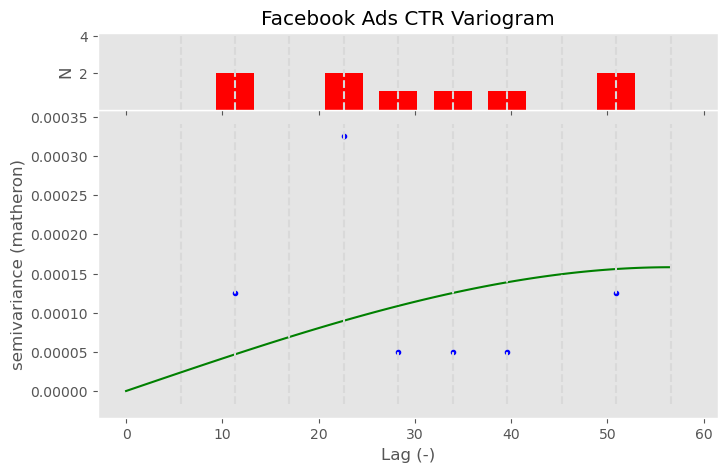

In [2]:
locations = np.array([[10, 20], [15, 25], [30, 35], [45, 50], [50, 60]])
ctr = np.array([0.05, 0.07, 0.04, 0.06, 0.05])

variogram = Variogram(coordinates=locations, values=ctr, model='spherical')
variogram.plot()
plt.title('Facebook Ads CTR Variogram')
plt.show()

**Variogram Plot Breakdown:**
- The `data points (blue dots)` represent the different semivariance values (which are how different two point-pairs are varied in their values - so in facebook ads, how CTR differs among two users) at different lag distances (geographical location of users).
- The `semivariance line (green line)` shows that as the distance increases (between users geographic locations), the values become more dissimilar (CTRs vary more).
    - The semivariance increases with distance but the rise is really slow showing moderate spatial correlation. It eventually plateaus where distance no longer correlates with CTR.
- The `histogram on top` shows the point pairs (number of user pairs) within the same distance interval (lag range). The higher bar means the more user pairs are used to calculate the smivariance, making the semivariance estimates at that distance, more reliable. The empty bars at specific distance means that there are no users at that distance interval.

### Random Natural Gas Dataset

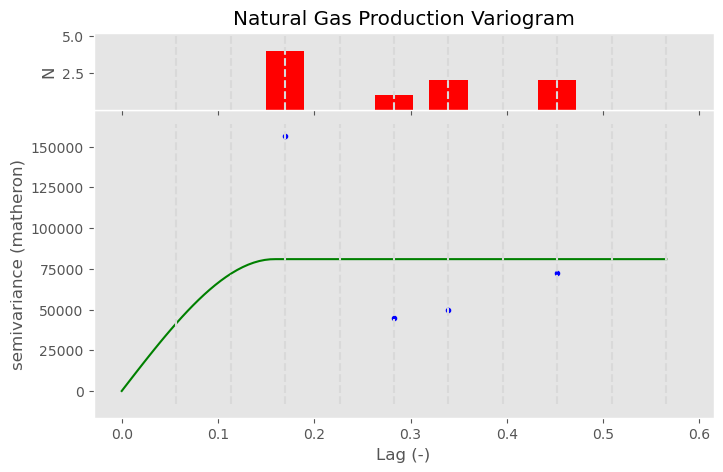

In [3]:
long_lat_coordinates = np.array([
    [-101.5, 34.2], [-101.6, 34.3], [-101.7, 34.4], [-101.8, 34.5], [-101.9, 34.6]])
gas_production = np.array([1500, 1800, 1200, 2000, 1600])

variogram = Variogram(coordinates=long_lat_coordinates, values=gas_production)
variogram.plot()
plt.title('Natural Gas Production Variogram')
plt.show()

**Variogram Plot Breakdown:**
- The `data points (blue dots)` represent the different semivariance values (which are how 2 wells close together vary in gas production) at similar distance ranges. These points are used to calculate the semivariance (green) line.
- The `semivariance line (green line)` rises steeply and then levels off;
    - Showing that gas production values of wells are very similar for those wells that are close together, and differences in gas production eventually no longer depend on the proximity of their distance.
- The `histogram on top` show how many pairs of wells (point pairs) contibute to each lag interval.
    - A higher bar means that there are more pairs (wells close together) at that distance range contributing to the semivariance calculation meaning more reliability because its based on a larger sample size.
    - A lower bar reflects that there are fewer pairs (wells close together) at that distance (lag) range, contributing to the semivariance calculation meaning less reliability, likely sampling noise.

### Spatially Correlated vs Uncorrelated Gas Production

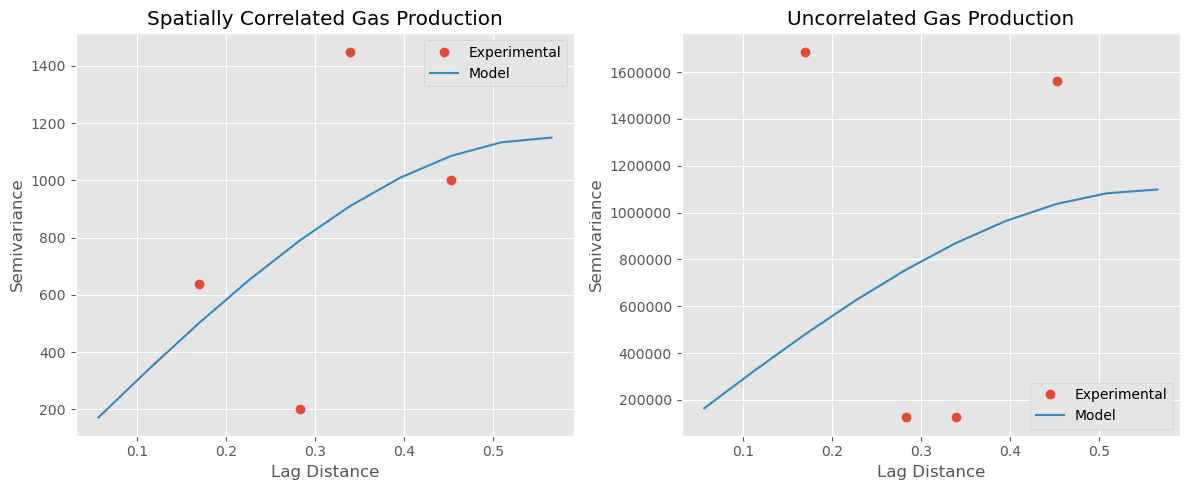

In [4]:
locations_correlated = np.array([
    [-101.5, 34.2], [-101.6, 34.3], [-101.7, 34.4], [-101.8, 34.5], [-101.9, 34.6]])
gas_production_correlated = np.array([1500, 1550, 1520, 1480, 1490])
variogram_correlated = Variogram(coordinates=locations_correlated, values=gas_production_correlated, model='spherical')

locations_uncorrelated = np.array([
    [-101.5, 34.2], [-101.6, 34.3], [-101.7, 34.4], [-101.8, 34.5], [-101.9, 34.6]])
gas_production_uncorrelated = np.array([1500, 2500, 1000, 3000, 500])
variogram_uncorrelated = Variogram(coordinates=locations_uncorrelated, values=gas_production_uncorrelated, model='spherical')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title('Spatially Correlated Gas Production')
ax1.plot(variogram_correlated.bins, variogram_correlated.experimental, 'o', label='Experimental')
ax1.plot(variogram_correlated.bins, variogram_correlated.fitted_model(variogram_correlated.bins), '-', label='Model')
ax1.set_xlabel('Lag Distance')
ax1.set_ylabel('Semivariance')
ax1.legend()

ax2.set_title('Uncorrelated Gas Production')
ax2.plot(variogram_uncorrelated.bins, variogram_uncorrelated.experimental, 'o', label='Experimental')
ax2.plot(variogram_uncorrelated.bins, variogram_uncorrelated.fitted_model(variogram_uncorrelated.bins), '-', label='Model')
ax2.set_xlabel('Lag Distance')
ax2.set_ylabel('Semivariance')
ax2.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Change scientific notation
ax2.ticklabel_format(style='plain', axis='y')  # Ensure numbers are in plain format
ax2.legend()

plt.tight_layout()
plt.show()

**Spatially Correlated**
- The gas production values are similar for wells that are close together, as shown by the trend of red dots increasing as semivariance increases. This means that gas production values are spatially correlated because as distance increases, gas production value increases.
- This trend is shown by the gradual increase of the semivariance (blue) line which is also within the same scale of semivariance (y-axis goes up in increments of a small number in the scale of semivariance values).

**Spatially Uncorrelated**
- Despite wells being close together, gas production values vary extremely as shown by the lower distance having a higher semivariance value (first red dot all the way on top) and as the next two semivariance values being really low as distance increases (two red dots on the bottom).
- This shows a lack of spatial correlation, no prevalent pattern / trend. The slope looks similar but its actually MUCH larger because of the intervals of the semivariance values on the y-axis, the difference is almost 200,000 compared to the small interval differences in the spatially correlated variogram plot.

**RECAP**
- Semivariance line shows tha variation between points as distance increases
- The data points show the semivariance values of clustered points at different lag distances
- The slope indicates correlation because a gradual increase shows spatial correlation as values change smoothly with distance, and a steep / erratic slope shows weak / lack of correlation

## Pancake Dataset

     x    y    v
0  382   69  230
1  444  403  112
2  491  297  114
3  444  316  112
4  296  146  224
(500, 3)


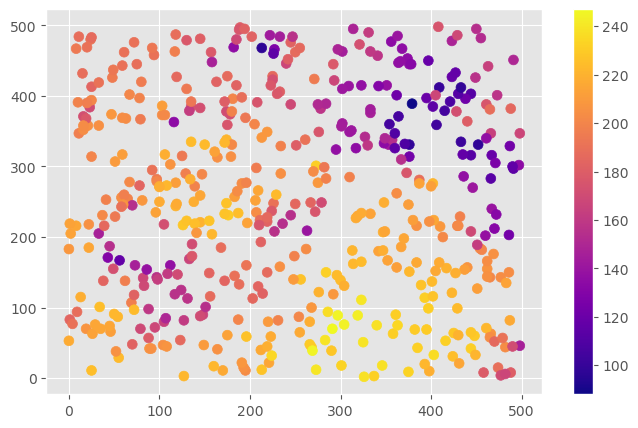

In [29]:
print(df_pancake.head())
print(df_pancake.shape)
fig, ax = plt.subplots(1, 1, figsize=(8,5))
meuse_plot = ax.scatter(np.array(df_pancake['x']), np.array(df_pancake['y']), s=50, c=np.array(df_pancake['v']).flatten(), cmap='plasma')
plt.colorbar(meuse_plot)
plt.show()
plt.close()

### Pancake Variogram

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 210085.73835850792,
 'normalized_sill': 1791240.756266547,
 'normalized_nugget': 0,
 'effective_range': 311.75859064099785,
 'sill': 1210.1958713044382,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


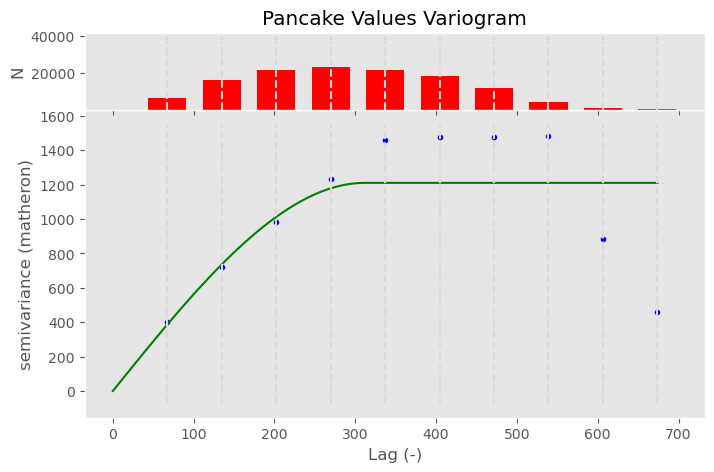

In [6]:
xy_pancake = np.array(df_pancake[['x','y']].values)
v_pancake = np.array(df_pancake['v'].values)

variogram = Variogram(coordinates=xy_pancake, values=v_pancake)
pprint.pp(variogram.describe())
variogram.plot()
plt.title('Pancake Values Variogram')
plt.show()
plt.close()

It looks like pancake values are spatially correlated normally as the distance increases, up until around lag distance nearing 300, where the semivariance plateaus and the distance no longer correlates with pancake values. The (x,y) locations before lag distance 300 have similar pancake values, meaning they don't vary as much, relatively consistent.

### Pancake Kriging

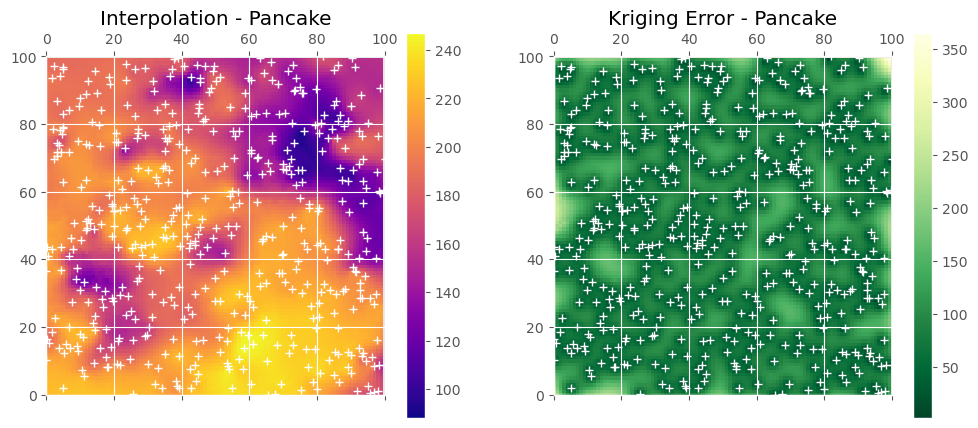

Root Mean-Squared Error: 2.691072152075028e-13
Root Mean-Square-Standardized: 24.57131991350609
Mean Standardized Error: -2.42368746947311
Average Standard Error: -4.751602273489697e-15


In [7]:
ok = OrdinaryKriging(variogram)
x = xy_pancake[:, 0]
y = xy_pancake[:, 1]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

interpolation = axes[0].matshow(field.T, origin='lower', cmap='plasma', vmin=v_pancake.min(), vmax=v_pancake.max())
axes[0].set_title('Interpolation - Pancake')
axes[0].plot(x_, y_, '+w')
axes[0].set_xlim((0, 100))
axes[0].set_ylim((0, 100))
plt.colorbar(interpolation, ax=axes[0])

error = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error - Pancake')
axes[1].plot(x_, y_, '+w')
axes[1].set_xlim((0, 100))
axes[1].set_ylim((0, 100))
plt.colorbar(error, ax=axes[1])

plt.show()
plt.close()

pred = ok.transform(xy_pancake)
actual = v_pancake
rmse = np.sqrt(mean_squared_error(actual, pred))
s2 = ok.sigma
rmss = np.sqrt(np.mean(((actual - pred) / s2) ** 2))
mse = np.mean((actual - pred) / s2)
avg_std_error = np.mean(s2)

print(f'Root Mean-Squared Error: {rmse}')
print(f'Root Mean-Square-Standardized: {rmss}')
print(f'Mean Standardized Error: {mse}')
print(f'Average Standard Error: {avg_std_error}')

### Pancake - Hyperparameter Tuning

Best parameters found: {'model': 'exponential', 'range': 50, 'sill': 0.5, 'nugget': 0.0, 'min_points': 2, 'max_points': 20}
Best CV score: 5.241156691380497


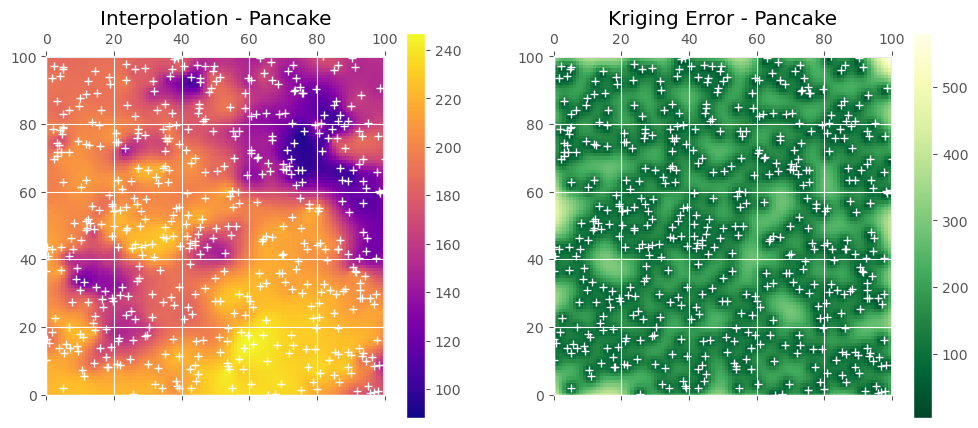

Root Mean-Squared Error: 3.654892594662823e-13
Root Mean-Square-Standardized: 7.754166061049001
Mean Standardized Error: -0.3705875339125812
Average Standard Error: -3.025096161358611e-14


In [8]:
param_grid = {    
    'model': ['spherical', 'exponential', 'gaussian'],
    'range': [50, 100, 200],
    'sill': [0.5, 1.0, 1.5],
    'nugget': [0.0, 0.1, 0.2],
    'min_points': [2, 3, 5], 
    'max_points': [10, 15, 20] 
}

best_score = float('inf')
best_params = {}

for model, rng, sill, nug, min_pts, max_pts in product(param_grid['model'], param_grid['range'], param_grid['sill'], param_grid['nugget'], param_grid['min_points'], param_grid['max_points']):
    variogram = Variogram(coordinates=xy_pancake, values=v_pancake, model=model, range=rng, sill=sill, nugget=nug)
    kriging = OrdinaryKriging(variogram, min_points=min_pts, max_points=max_pts)
    kf = KFold(n_splits=5)
    scores = []

    for train_index, test_index in kf.split(xy_pancake):
        X_train, X_test = xy_pancake[train_index], xy_pancake[test_index]
        y_train, y_test = v_pancake[train_index], v_pancake[test_index]
        y_pred = kriging.transform(X_test)
        if np.isnan(y_pred).any():
            y_pred = np.nan_to_num(y_pred, nan=np.nanmean(y_pred))
        
        s2 = kriging.sigma
        rmss = np.sqrt(np.mean(((y_test - y_pred) / s2) ** 2))
        scores.append(np.abs(rmss - 1))

    avg_score = np.mean(scores)
    if avg_score < best_score:
        best_score = avg_score
        best_params = {'model': model, 'range': rng, 'sill': sill, 'nugget': nug, 'min_points': min_pts, 'max_points': max_pts}

print('Best parameters found:', best_params)
print('Best CV score:', best_score)

best_variogram = Variogram(coordinates=xy_pancake, values=v_pancake, **best_params)
ok = OrdinaryKriging(best_variogram, min_points=best_params['min_points'], max_points=best_params['max_points'])
x = xy_pancake[:, 0]
y = xy_pancake[:, 1]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

interpolation = axes[0].matshow(field.T, origin='lower', cmap='plasma', vmin=v_pancake.min(), vmax=v_pancake.max())
axes[0].set_title('Interpolation - Pancake')
axes[0].plot(x_, y_, '+w')
axes[0].set_xlim((0, 100))
axes[0].set_ylim((0, 100))
plt.colorbar(interpolation, ax=axes[0])

error = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error - Pancake')
axes[1].plot(x_, y_, '+w')
axes[1].set_xlim((0, 100))
axes[1].set_ylim((0, 100))
plt.colorbar(error, ax=axes[1])

plt.show()
plt.close()

pred = ok.transform(xy_pancake)
actual = v_pancake
rmse = np.sqrt(mean_squared_error(actual, pred))
s2 = ok.sigma
rmss = np.sqrt(np.mean(((actual - pred) / s2) ** 2))
mse = np.mean((actual - pred) / s2)
avg_std_error = np.mean(s2)

print(f'Root Mean-Squared Error: {rmse}')
print(f'Root Mean-Square-Standardized: {rmss}')
print(f'Mean Standardized Error: {mse}')
print(f'Average Standard Error: {avg_std_error}')

Areas of Interest on the Interpoloation Plot:

	1. Brightest and Densest Region:
	  • Coordinates: Around (40, 20).
	  • Characteristics: High predicted values (yellow color) and a high density of data points (white dots).
	2. Dark Regions with Dense Clusters:
      • Coordinates: Around (60, 80) and (20, 40).
	  • Characteristics: Lower predicted values (darker color) but with a high concentration of data points.
	3. Regions with Gradual Color Transition:
	  • Coordinates: Around (80, 60).
	  • Characteristics: Moderate predicted values with a more even distribution of data points.
	4. Areas with Sparse Data Points:
	  • Coordinates: Top-left corner and bottom-right areas.
	  • Characteristics: Less dense data points and varying colors, indicating less certainty in predictions.


Areas of Interest on the Kriging Error Plot:

	1. Lowest Error Regions (Dark Green):
	  • Coordinates: Around (20, 60) and (40, 20).
	  • Characteristics: Very low kriging error, indicating high confidence in predictions. 
        These areas are densely populated with data points.
	2. Moderate Error Regions (Medium Green):
	  • Coordinates: Around (60, 80) and (80, 40).
	  • Characteristics: Moderate kriging error. These regions have data points but not as densely clustered, 
        leading to moderate prediction confidence.
	3. Highest Error Regions (Light Yellow):
	  • Coordinates: Around (0, 80) and (100, 40).
	  • Characteristics: High kriging error, indicating low confidence in predictions due to sparse 
        or unevenly distributed data points in these areas.

Overall Analysis of the Pancake Dataset:

	1. Best Location for Low Error and High Interpolation:
	  • Coordinates: Around (40, 20).
	  • Characteristics: This region shows high predicted values (yellow on the interpolation plot) and low kriging error (dark green on the error plot). This makes it the most reliable area for predictions.
	2. High Confidence, Moderate Predictions:
	  • Coordinates: Around (20, 60).
	  • Characteristics: Although not as bright as the best location, this area still shows low error with decent interpolation values, indicating reliable but moderate predictions.
	3. Moderate Confidence, Moderate Predictions:
	  • Coordinates: Around (60, 80) and (80, 40).
	  • Characteristics: These regions show moderate error and moderate interpolation values. Predictions here are reliable but less certain than in the best areas.
	4. Areas of High Uncertainty:
	  • Coordinates: Around (0, 80) and (100, 40).
	  • Characteristics: These regions show high kriging error and lower interpolation values, making predictions here less reliable.

**Summary:**

*The most reliable predictions with high interpolation and low error occur around (40, 20)*

## Aniso Dataset

     x    y    v
0  382   69  163
1  444  403  155
2  491  297  170
3  444  316  183
4  296  146   70
(500, 3)


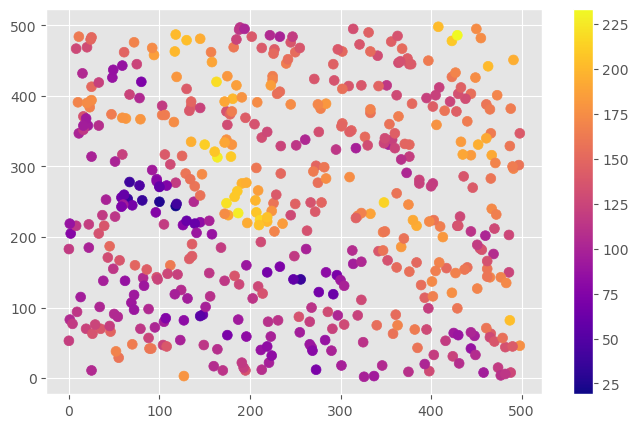

In [28]:
print(df_aniso.head())
print(df_aniso.shape)
fig, ax = plt.subplots(1, 1, figsize=(8,5))
meuse_plot = ax.scatter(np.array(df_aniso['x']), np.array(df_aniso['y']), s=50, c=np.array(df_aniso['v']).flatten(), cmap='plasma')
plt.colorbar(meuse_plot)
plt.show()
plt.close()

### Aniso Variogram

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 102235.869792168,
 'normalized_sill': 2147110.3970900695,
 'normalized_nugget': 0,
 'effective_range': 151.7138237388216,
 'sill': 1389.003278337458,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


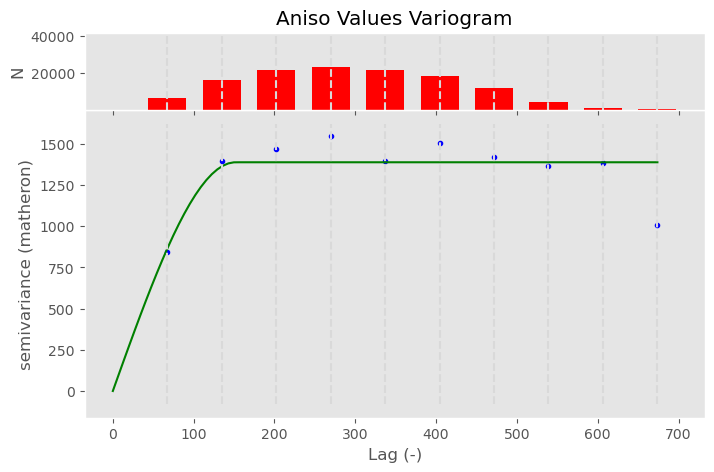

In [10]:
xy_aniso = np.array(df_aniso[['x','y']].values)
v_aniso = np.array(df_aniso['v'].values)

variogram = Variogram(coordinates=xy_aniso, values=v_aniso)
pprint.pp(variogram.describe())
variogram.plot()
plt.title('Aniso Values Variogram')
plt.show()
plt.close()

### Aniso Kriging

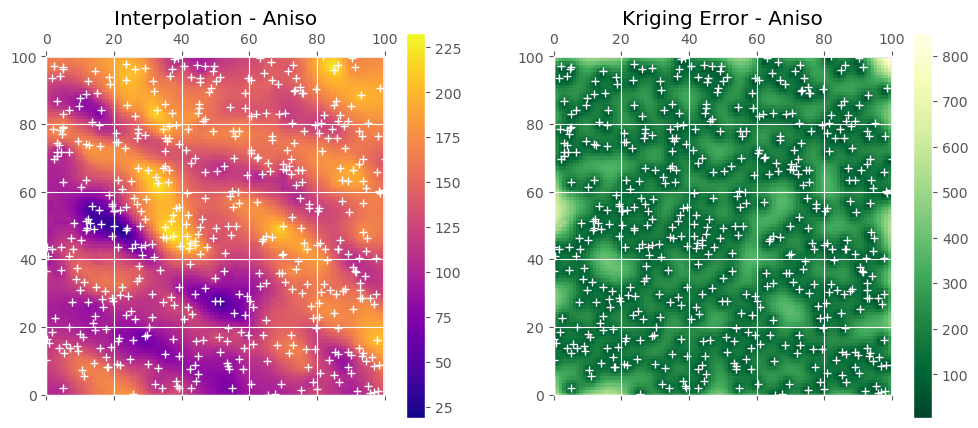

Root Mean-Squared Error: 2.0567193092461537e-13
Root Mean-Square-Standardized: 3.3818183613615482
Mean Standardized Error: -0.013173373412110714
Average Standard Error: 7.948192184959885e-15


In [11]:
ok = OrdinaryKriging(variogram)
x = xy_aniso[:, 0]
y = xy_aniso[:, 1]
xx, yy = np.mgrid[x.min(): x.max(): 100j, y.min(): y.max(): 100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

interpolation = axes[0].matshow(field.T, origin='lower', cmap='plasma', vmin=v_aniso.min(), vmax=v_aniso.max())
axes[0].set_title('Interpolation - Aniso')
axes[0].plot(x_, y_, '+w')
axes[0].set_xlim((0,100))
axes[0].set_ylim((0,100))
plt.colorbar(interpolation, ax=axes[0])

error = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error - Aniso')
axes[1].plot(x_, y_, 'w+')
axes[1].set_xlim((0,100))
axes[1].set_ylim((0,100))
plt.colorbar(error, ax=axes[1])

plt.show()
plt.close()

pred = ok.transform(xy_aniso)
actual = v_aniso
rmse = np.sqrt(mean_squared_error(actual, pred))
s2 = ok.sigma
rmss = np.sqrt(np.mean(((actual - pred) / s2) ** 2))
mse = np.mean((actual - pred) / s2)
avg_std_error = np.mean(s2)

print(f'Root Mean-Squared Error: {rmse}')
print(f'Root Mean-Square-Standardized: {rmss}')
print(f'Mean Standardized Error: {mse}')
print(f'Average Standard Error: {avg_std_error}')

### Aniso Kriging - Hyperparameter Tuning

Best parameters found: {'model': 'spherical', 'range': 50, 'sill': 0.5, 'nugget': 0.0, 'min_points': 2, 'max_points': 10}
Best CV score: 1.452371559005741


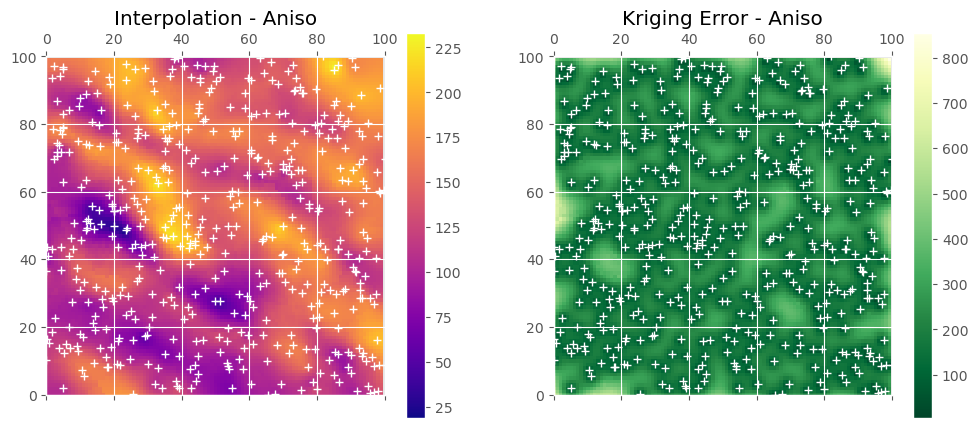

Root Mean-Squared Error: 1.0050551019952993e-13
Root Mean-Square-Standardized: 2.5570371382716166
Mean Standardized Error: -0.03832980166884804
Average Standard Error: -1.2777985549212455e-14


In [12]:
param_grid = {    
    'model': ['spherical', 'exponential', 'gaussian'],
    'range': [50, 100, 150],
    'sill': [0.5, 1.0, 1.5],
    'nugget': [0.0, 0.05, 0.1],
    'min_points': [2, 3, 5],
    'max_points': [10, 15, 20]
}

best_score = float('inf')
best_params = {}

for model, rng, sill, nug, min_pts, max_pts in product(param_grid['model'], param_grid['range'], param_grid['sill'], param_grid['nugget'], param_grid['min_points'], param_grid['max_points']):
    variogram = Variogram(coordinates=xy_aniso, values=v_aniso, model=model, range=rng, sill=sill, nugget=nug)
    kriging = OrdinaryKriging(variogram, min_points=min_pts, max_points=max_pts)
    kf = KFold(n_splits=5)
    scores = []

    for train_index, test_index in kf.split(xy_aniso):
        X_train, X_test = xy_aniso[train_index], xy_aniso[test_index]
        y_train, y_test = v_aniso[train_index], v_aniso[test_index]
        y_pred = kriging.transform(X_test)
        if np.isnan(y_pred).any():
            y_pred = np.nan_to_num(y_pred, nan=np.nanmean(y_pred))
        
        s2 = kriging.sigma
        rmss = np.sqrt(np.mean(((y_test - y_pred) / s2) ** 2))
        scores.append(np.abs(rmss - 1))

    avg_score = np.mean(scores)
    if avg_score < best_score:
        best_score = avg_score
        best_params = {'model': model, 'range': rng, 'sill': sill, 'nugget': nug, 'min_points': min_pts, 'max_points': max_pts}

print('Best parameters found:', best_params)
print('Best CV score:', best_score)

best_variogram = Variogram(coordinates=xy_aniso, values=v_aniso, **best_params)
ok = OrdinaryKriging(best_variogram, min_points=best_params['min_points'], max_points=best_params['max_points'])
x = xy_aniso[:, 0]
y = xy_aniso[:, 1]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

interpolation = axes[0].matshow(field.T, origin='lower', cmap='plasma', vmin=v_aniso.min(), vmax=v_aniso.max())
axes[0].set_title('Interpolation - Aniso')
axes[0].plot(x_, y_, '+w')
axes[0].set_xlim((0, 100))
axes[0].set_ylim((0, 100))
plt.colorbar(interpolation, ax=axes[0])

error = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error - Aniso')
axes[1].plot(x_, y_, '+w')
axes[1].set_xlim((0, 100))
axes[1].set_ylim((0, 100))
plt.colorbar(error, ax=axes[1])

plt.show()
plt.close()

pred = ok.transform(xy_aniso)
actual = v_aniso
rmse = np.sqrt(mean_squared_error(actual, pred))
s2 = ok.sigma
rmss = np.sqrt(np.mean(((actual - pred) / s2) ** 2))
mse = np.mean((actual - pred) / s2)
avg_std_error = np.mean(s2)

print(f'Root Mean-Squared Error: {rmse}')
print(f'Root Mean-Square-Standardized: {rmss}')
print(f'Mean Standardized Error: {mse}')
print(f'Average Standard Error: {avg_std_error}')

## Meuse Dataset

        x       y    v
0  181072  333611  299
1  181025  333558  277
2  181165  333537  199
3  181298  333484  116
4  181307  333330  117
(155, 3)


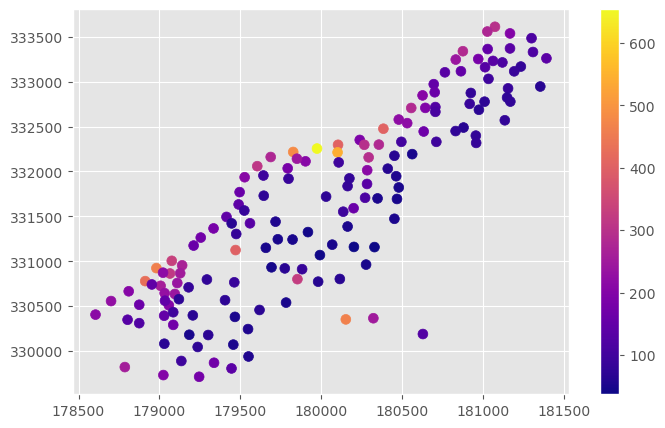

In [27]:
print(df_meuse.head())
print(df_meuse.shape)
fig, ax = plt.subplots(1, 1, figsize=(8,5))
meuse_plot = ax.scatter(np.array(df_meuse['x']), np.array(df_meuse['y']), s=50, c=np.array(df_meuse['v']).flatten(), cmap='plasma')
plt.colorbar(meuse_plot)
plt.show()
plt.close()

### Meuse Variogram

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 3382925.7255126247,
 'normalized_sill': 171145914.50783175,
 'normalized_nugget': 0,
 'effective_range': 761.7890660110571,
 'sill': 10700.58683442606,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


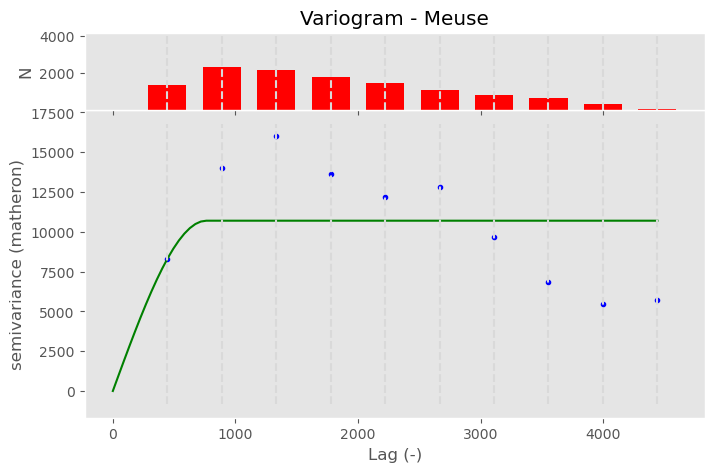

In [14]:
xy_meuse = np.array(df_meuse[['x','y']].values)
v_meuse = np.array(df_meuse['v'].values)

variogram = Variogram(coordinates=xy_meuse, values=v_meuse)
pprint.pp(variogram.describe())
variogram.plot()
plt.title('Variogram - Meuse')
plt.show()
plt.close()

### Meuse Kriging

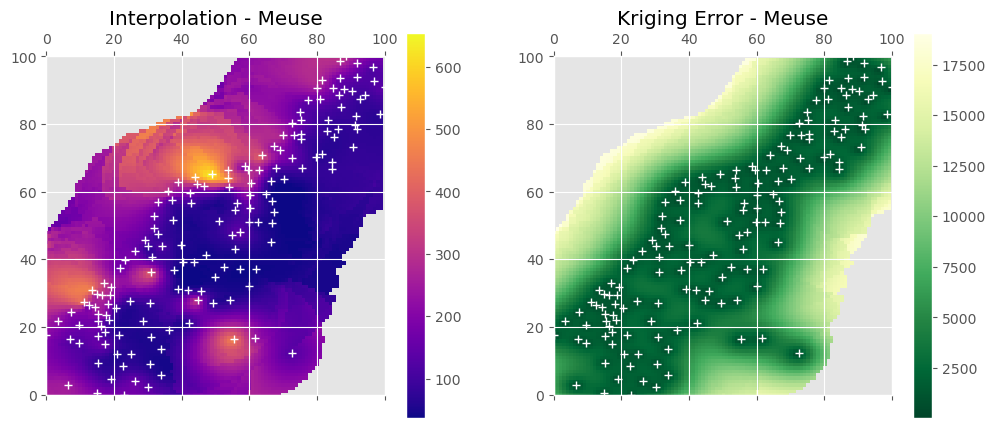

Root Mean-Squared Error: 3.743055279797027e-13
Root Mean-Square-Standardized: 0.35400931193325974
Mean Standardized Error: -0.02835455882093277
Average Standard Error: 2.7971483294809117e-13


In [15]:
ok = OrdinaryKriging(variogram, min_points=3)
x = xy_meuse[:,0]
y = xy_meuse[:,1]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

fig, axes = plt.subplots(1,2, figsize=(12,5))
x_ = (x-x.min()) / (x.max()-x.min()) * 100
y_ = (y-y.min()) / (y.max()-y.min()) * 100

interpolation = axes[0].matshow(field.T, origin='lower', cmap='plasma', vmin=v_meuse.min(), vmax=v_meuse.max())
axes[0].set_title('Interpolation - Meuse')
axes[0].plot(x_, y_, 'w+')
axes[0].set_xlim((0,100))
axes[0].set_ylim((0,100))
plt.colorbar(interpolation, ax=axes[0])

error = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error - Meuse')
axes[1].plot(x_, y_, 'w+')
axes[1].set_xlim((0,100))
axes[1].set_ylim((0,100))
plt.colorbar(error, ax=axes[1])

plt.show()
plt.close()

pred = ok.transform(xy_meuse)
actual = v_meuse
rmse = np.sqrt(mean_squared_error(actual, pred))
s2 = ok.sigma
rmss = np.sqrt(np.mean(((actual - pred) / s2) ** 2))
mse = np.mean((actual - pred) / s2)
avg_std_error = np.mean(s2)

print(f'Root Mean-Squared Error: {rmse}')
print(f'Root Mean-Square-Standardized: {rmss}')
print(f'Mean Standardized Error: {mse}')
print(f'Average Standard Error: {avg_std_error}')

### Meuse - Hyperparameter Tuning

Best parameters found: {'model': 'exponential', 'range': 50, 'sill': 0.5, 'nugget': 0.0, 'min_points': 2, 'max_points': 15}
Best CV score: 0.5095612694272258


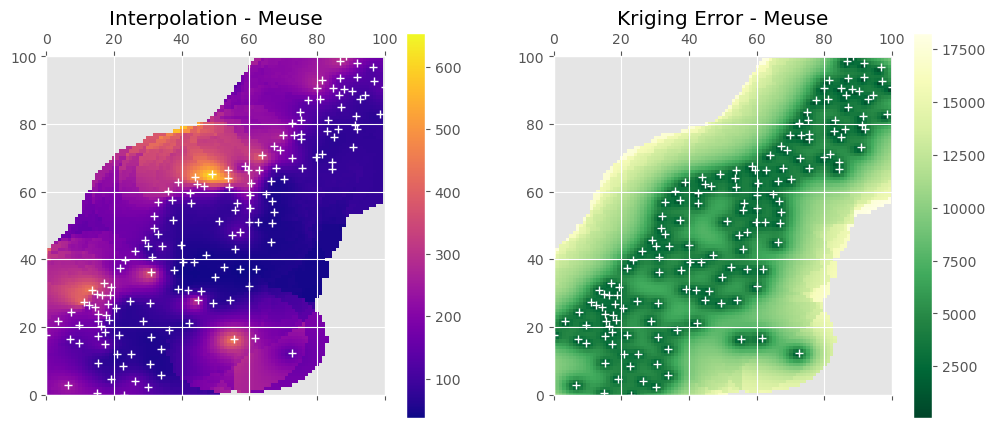

Root Mean-Squared Error: 1.915627908572637e-13
Root Mean-Square-Standardized: 0.8038841085626659
Mean Standardized Error: -0.11743952695514534
Average Standard Error: -1.6909847073311905e-13


In [16]:
param_grid = {    
    'model': ['spherical', 'exponential', 'gaussian'],
    'range': [50, 100, 150],
    'sill': [0.5, 1.0, 1.5],
    'nugget': [0.0, 0.05, 0.1],
    'min_points': [2, 3, 5],
    'max_points': [10, 15, 20]
}

best_score = float('inf')
best_params = {}

for model, rng, sill, nug, min_pts, max_pts in product(param_grid['model'], param_grid['range'], param_grid['sill'], param_grid['nugget'], param_grid['min_points'], param_grid['max_points']):
    variogram = Variogram(coordinates=xy_meuse, values=v_meuse, model=model, range=rng, sill=sill, nugget=nug)
    kriging = OrdinaryKriging(variogram, min_points=min_pts, max_points=max_pts)
    kf = KFold(n_splits=5)
    scores = []

    for train_index, test_index in kf.split(xy_meuse):
        X_train, X_test = xy_meuse[train_index], xy_meuse[test_index]
        y_train, y_test = v_meuse[train_index], v_meuse[test_index]
        y_pred = kriging.transform(X_test)
        if np.isnan(y_pred).any():
            y_pred = np.nan_to_num(y_pred, nan=np.nanmean(y_pred))
        
        s2 = kriging.sigma
        rmss = np.sqrt(np.mean(((y_test - y_pred) / s2) ** 2))
        scores.append(np.abs(rmss - 1))

    avg_score = np.mean(scores)
    if avg_score < best_score:
        best_score = avg_score
        best_params = {'model': model, 'range': rng, 'sill': sill, 'nugget': nug, 'min_points': min_pts, 'max_points': max_pts}

print('Best parameters found:', best_params)
print('Best CV score:', best_score)

best_variogram = Variogram(coordinates=xy_meuse, values=v_meuse, **best_params)
ok = OrdinaryKriging(best_variogram, min_points=best_params['min_points'], max_points=best_params['max_points'])
x = xy_meuse[:, 0]
y = xy_meuse[:, 1]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

interpolation = axes[0].matshow(field.T, origin='lower', cmap='plasma', vmin=v_meuse.min(), vmax=v_meuse.max())
axes[0].set_title('Interpolation - Meuse')
axes[0].plot(x_, y_, 'w+')
axes[0].set_xlim((0, 100))
axes[0].set_ylim((0, 100))
plt.colorbar(interpolation, ax=axes[0])

error = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error - Meuse')
axes[1].plot(x_, y_, 'w+')
axes[1].set_xlim((0, 100))
axes[1].set_ylim((0, 100))
plt.colorbar(error, ax=axes[1])

plt.show()
plt.close()

pred = ok.transform(xy_meuse)
actual = v_meuse
rmse = np.sqrt(mean_squared_error(actual, pred))
s2 = ok.sigma
rmss = np.sqrt(np.mean(((actual - pred) / s2) ** 2))
mse = np.mean((actual - pred) / s2)
avg_std_error = np.mean(s2)

print(f'Root Mean-Squared Error: {rmse}')
print(f'Root Mean-Square-Standardized: {rmss}')
print(f'Mean Standardized Error: {mse}')
print(f'Average Standard Error: {avg_std_error}')

## Script

In [17]:
try:
    print('Script executed successfully.')
except:
    print('FAILED')

Script executed successfully.
